# PREPROCESSOR & GALILEO

In [3]:
# Create galileo.py and preprocessor.py in Colab
# Run this cell to create the files

# Create preprocessor.py
%%writefile preprocessor.py
import pandas as pd
import numpy as np
import scipy.signal as signal


def load_data(file_path):
    """
    Load a CSV file and convert timestamp to datetime if present.

    Args:
        file_path (str): Path to the CSV file

    Returns:
        pandas.DataFrame: Loaded data or None if error
    """
    try:
        df = pd.read_csv(file_path)
        if 'timestamp' in df.columns:
            df['date'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None


def filter_window(window, epsilon=0.1, target_column=None):
    """
    Filter a window of data by identifying values that are within epsilon of the mean.

    Args:
        window (pandas.DataFrame): Window of data to filter
        epsilon (float): Tolerance as a percentage
        target_column (str, optional): Specific column to filter. If provided, only this column will be filtered.

    Returns:
        pandas.DataFrame: Mask of values to keep
    """
    filter_columns = []

    # If target column is specified, only filter that column
    if target_column and target_column in window.columns:
        filter_columns = [target_column]
    else:
        # Otherwise, filter all relevant columns
        if 'frequency' in window.columns:
            filter_columns.append('frequency')

        for prefix in ['V', 'C']:
            for i in range(1, 4):
                col = f"{prefix}{i}"
                col_lower = col.lower()
                matching_cols = [c for c in window.columns if c.lower() == col_lower]
                if matching_cols:
                    filter_columns.extend(matching_cols)

        power_cols = [col for col in window.columns if 'power' in col.lower()]
        filter_columns.extend(power_cols)

    filter_columns = [col for col in filter_columns if col in window.columns]
    filter_columns = [col for col in filter_columns if np.issubdtype(window[col].dtype, np.number)]

    if not filter_columns:
        print("Warning: No valid columns to filter on.")
        return pd.DataFrame(True, index=window.index, columns=window.columns)

    keep_mask = pd.DataFrame(True, index=window.index, columns=window.columns)

    for column in filter_columns:
        if window[column].isna().all() or (window[column] == 0).all():
            continue

        avg = window[column].mean()

        lower_bound = avg - abs(avg * epsilon)
        upper_bound = avg + abs(avg * epsilon)

        within_range = (window[column] >= lower_bound) & (window[column] <= upper_bound)

        keep_mask[column] = within_range

    return keep_mask


def filter_data(df, window_size=10, epsilon=0.1, target_column=None):
    """
    Filter data by applying window-based filtering.

    Args:
        df (pandas.DataFrame): Data to filter
        window_size (int): Size of the window for filtering
        epsilon (float): Tolerance as a percentage
        target_column (str, optional): Specific column to filter. If provided, only this column will be filtered
                                      and rows will only be dropped if this column contains null values.

    Returns:
        pandas.DataFrame: Filtered data
    """
    filtered_df = df.copy()

    total_windows = 0
    total_cells = 0
    nullified_cells = 0

    for i in range(0, len(df), window_size):
        window = df.iloc[i:i+window_size]

        if len(window) < window_size:
            continue

        total_windows += 1

        keep_mask = filter_window(window, epsilon, target_column)

        # For single column analysis, only operate on that column
        if target_column:
            if target_column in keep_mask.columns:
                total_cells += len(window[target_column])
                nullified_values = (~keep_mask[target_column]).sum()
                nullified_cells += nullified_values

                filtered_df.loc[window.index[~keep_mask[target_column]], target_column] = np.nan
        else:
            # For multiple column analysis, operate on all columns
            for col in window.columns:
                if col in keep_mask.columns:
                    total_cells += len(window[col])
                    nullified_values = (~keep_mask[col]).sum()
                    nullified_cells += nullified_values

                    filtered_df.loc[window.index[~keep_mask[col]], col] = np.nan

    return filtered_df


def moving_average_filter(data, window_size):
    """
    Apply a moving average filter to the data.

    Args:
        data (numpy.ndarray): Data to filter
        window_size (int): Size of the moving window

    Returns:
        numpy.ndarray: Filtered data
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')


def butterworth_filter(data, cutoff, fs, order=4):
    """
    Apply a Butterworth low-pass filter to the data.

    Args:
        data (numpy.ndarray): Data to filter
        cutoff (float): Cutoff frequency
        fs (float): Sampling frequency
        order (int): Filter order

    Returns:
        numpy.ndarray: Filtered data
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, data)


def savgol_filter(data, window_size, poly_order):
    """
    Apply a Savitzky-Golay filter to the data.

    Args:
        data (numpy.ndarray): Data to filter
        window_size (int): Size of the window
        poly_order (int): Order of the polynomial

    Returns:
        numpy.ndarray: Filtered data
    """
    return signal.savgol_filter(data, window_size, poly_order)


def extract_noise_signal(df, filter, window_size=5, cutoff=0.1, fs=1.0, poly_order=2, keep_noise_only=True, target_column=None):
    """
    Extract noise from signals using various filtering methods.

    Args:
        df (pandas.DataFrame): Data containing signals
        filter (str): Type of filter to use ('moving_average', 'butterworth', 'savgol')
        window_size (int): Size of the window for filtering
        cutoff (float): Cutoff frequency for Butterworth filter
        fs (float): Sampling frequency for Butterworth filter
        poly_order (int): Polynomial order for Savitzky-Golay filter
        keep_noise_only (bool): If True, return only the noise component
        target_column (str, optional): Specific column to extract noise from. If provided, only this column will be processed.

    Returns:
        pandas.DataFrame: Data with extracted noise signals
    """
    noise_signals = pd.DataFrame(index=df.index)

    # clean the data just in case
    df.dropna(inplace=True)

    # Select columns to process
    columns_to_process = [target_column] if target_column and target_column in df.columns else df.columns

    # noise extraction on each column
    for column in columns_to_process:
        if column == 'timestamp' or column == 'date':
            noise_signals[column] = df[column]
            continue

        data = df[column].values

        if filter == 'moving_average':
            noise_signals[column] = moving_average_filter(data, window_size=window_size)
        elif filter == 'butterworth':
            noise_signals[column] = butterworth_filter(data, cutoff=cutoff, fs=fs)
        elif filter == 'savgol':
            noise_signals[column] = savgol_filter(data, window_size=window_size, poly_order=poly_order)
        else:
            raise ValueError(f"Unknown filter type: {filter}")

        if keep_noise_only:
            noise_signals[column] = data - noise_signals[column]

    return noise_signals


Overwriting preprocessor.py


In [2]:
# Create galileo.py
%%writefile galileo.py
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import joblib
import os
from preprocessor import load_data as prep_load_data
from preprocessor import filter_data

def load_data(file_path):
    """Load and preprocess the CSV file using preprocessor functions."""
    try:
        df = prep_load_data(file_path)
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

def extract_features(signal):
    """Extract statistical features from a signal."""
    if len(signal) < 2:
        return None

    std = np.std(signal)
    mean = np.mean(signal)
    variance = std ** 2
    diffs = np.diff(signal)
    diff_mean = np.mean(np.abs(diffs))
    diff_std = np.std(diffs)

    std_perc = (std / mean * 100) if mean != 0 else 0
    diff_std_perc = diff_std / diff_mean if diff_mean != 0 else 0

    return {
        'std': std,
        'variance': variance,
        'std_perc': std_perc,
    }

def extract_window_features(df, window_size=10, target_column=None):
    """Extract features from a sliding window of the data with preprocessing."""
    # Validate target_column exists in data
    if target_column and target_column not in df.columns:
        print(f"Error: Specified column '{target_column}' not found in data.")
        print(f"Available columns: {', '.join(df.columns)}")
        return pd.DataFrame(), []

    measurement_types = {
        'current': ['C1', 'C2', 'C3'],
        'voltage': ['V1', 'V2', 'V3'],
        'power': ['power_real', 'power_effective', 'power_apparent'],
        'frequency' : ['frequency']
    }

    all_features = []
    feature_names = []

    epsilon = 0.08
    filtered_df = filter_data(df, window_size=window_size, epsilon=epsilon, target_column=target_column)

    for i in range(0, len(filtered_df), window_size//2):  # 50% overlap
        window = filtered_df.iloc[i:i+window_size].copy()

        # Skip if window is too small
        if len(window) < window_size:
            continue

        initial_size = window_size * len(window.columns)

        window = window.dropna()

        non_null_count_after = window.count().sum()

        # Skip window if it has less than 60% of its original data after removing nulls
        if non_null_count_after < 0.6 * initial_size:
            continue

        window_features = {}

        # If target_column is specified, only analyze that column
        if target_column:
            if target_column in filtered_df.columns:
                signal = window[target_column].values
                if len(signal) > 0:
                    features = extract_features(signal)
                    if features:
                        for fname, fval in features.items():
                            feature_name = f"{target_column}_{fname}"
                            window_features[feature_name] = fval
                            if feature_name not in feature_names:
                                feature_names.append(feature_name)
        else:
            # Otherwise, analyze all columns by category
            for category, columns in measurement_types.items():
                for col in columns:
                    if col in filtered_df.columns:
                        signal = window[col].values
                        if len(signal) > 0:
                            features = extract_features(signal)
                            if features:
                                for fname, fval in features.items():
                                    feature_name = f"{col}_{fname}"
                                    window_features[feature_name] = fval
                                    if feature_name not in feature_names:
                                        feature_names.append(feature_name)

        if window_features:
            all_features.append(window_features)

    return pd.DataFrame(all_features), feature_names

def calculate_feature_importance(svm, X, y, feature_names):
    """Calculate feature importance using permutation importance."""
    result = permutation_importance(svm, X, y, n_repeats=10, random_state=42)
    importance_scores = result.importances_mean

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)

    return importance_df

def plot_feature_importance(importance_df, title="Feature Importance"):
    """Plot feature importance scores."""
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importance_df)), importance_df['Importance'])
    plt.xticks(range(len(importance_df)), importance_df['Feature'], rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()

def train_svm(training_files, labels, target_column=None):
    """Train SVM classifier on multiple files."""
    all_features = []
    all_labels = []
    feature_names = None

    for file_path, label in zip(training_files, labels):
        df = load_data(file_path)
        if df is not None:
            features_df, curr_feature_names = extract_window_features(df, target_column=target_column)
            if not features_df.empty:
                all_features.append(features_df)
                all_labels.extend([label] * len(features_df))
                if feature_names is None:
                    feature_names = curr_feature_names

    if not all_features:
        print("No valid features extracted from training files")
        return None, None, None

    X = pd.concat(all_features, ignore_index=True)
    y = np.array(all_labels)

    # Handle NaN values
    X = X.fillna(0)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train SVM
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_scaled, y)

    # Calculate feature importance
    importance_df = calculate_feature_importance(svm, X_scaled, y, feature_names)
    plot_feature_importance(importance_df)

    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))

    return svm, scaler, feature_names

def analyze_file(file_path, svm, scaler, feature_names, target_column=None):
    """Analyze a single file using trained SVM."""
    df = load_data(file_path)
    if df is None:
        return None

    features_df, extracted_feature_names = extract_window_features(df, target_column=target_column)
    if features_df.empty:
        return None

    # Handle NaN values
    features_df = features_df.fillna(0)

    # Check if any required features are missing
    missing_features = [f for f in feature_names if f not in features_df.columns]
    if missing_features:
        print(f"Error: {len(missing_features)} features used in training were not found in analysis data:")
        for feature in missing_features[:5]:  # Print first 5 missing features for clarity
            print(f"  - Missing feature: '{feature}'")
        if len(missing_features) > 5:
            print(f"  - ... and {len(missing_features) - 5} more")
        print("\nAnalysis cannot proceed. Please ensure you're using the same column(s) for analysis as used in training.")
        return None

    # Create aligned features dataframe with same structure as training data
    aligned_features = pd.DataFrame(index=features_df.index)
    for feature in feature_names:
        aligned_features[feature] = features_df[feature]

    # Scale features
    X_scaled = scaler.transform(aligned_features)

    predictions = svm.predict(X_scaled)
    probabilities = svm.predict_proba(X_scaled)

    is_real = np.mean(predictions) > 0.5  # 1 for real, 0 for simulated
    confidence = np.mean(np.max(probabilities, axis=1)) * 100

    return {
        'classification': "REAL" if is_real else "SIMULATED",
        'confidence': int(confidence),
        'window_predictions': predictions,
        'window_probabilities': probabilities
    }

def train_and_save_model(training_files, labels, model_path, target_column=None):
    """Train SVM model and save it to the specified path."""
    svm, scaler, feature_names = train_svm(training_files, labels, target_column=target_column)

    if svm is not None:
        joblib.dump((svm, scaler, feature_names, target_column), model_path)
        print(f"\nModel saved to {model_path}")
        print("Feature importance plot saved as 'feature_importance.png'")
        return True

    return False

def analyze_with_model(file_path, model_path, target_column=None):
    """Load model and analyze the specified file."""
    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found")
        return None

    # Load model
    model_data = joblib.load(model_path)

    # Check if the model includes target_column information (for backward compatibility)
    if len(model_data) == 4:
        svm, scaler, feature_names, trained_column = model_data
    else:
        svm, scaler, feature_names = model_data
        trained_column = None

    # Use command line column if specified, otherwise use the column the model was trained on
    analysis_column = target_column if target_column else trained_column

    if analysis_column:
        print(f"Analyzing only column: {analysis_column}")
    else:
        print("Analyzing all columns")

    results = analyze_file(file_path, svm, scaler, feature_names, target_column=analysis_column)
    return results

Writing galileo.py


In [4]:
!pip install joblib scikit-learn pandas numpy matplotlib scipy

# FILE UPLOAD

In [ ]:
# Upload files using the file upload widget
from google.colab import files
uploaded = files.upload()


# HELPER FUNCTIONS

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from IPython.display import display, Markdown
import galileo

def parse_file_list(file_string):
    """Parse a comma-separated string of filenames into a list, with wildcard support."""
    import glob

    if not file_string or file_string.strip() == '':
        return []

    # Split by comma and strip spaces
    patterns = [f.strip() for f in file_string.split(',')]

    files = []
    for pattern in patterns:
        # If pattern contains wildcard, use glob to expand it
        if '*' in pattern:
            matched_files = glob.glob(pattern)
            if matched_files:
                files.extend(matched_files)
            else:
                print(f"⚠️ Warning: No files found matching pattern: {pattern}")
        else:
            # Regular file path
            files.append(pattern)

    # Verify files exist
    missing = [f for f in files if not os.path.exists(f)]
    if missing:
        print(f"⚠️ Warning: The following files were not found: {', '.join(missing)}")

    # Return only existing files
    return [f for f in files if os.path.exists(f)]
def display_results(results):
    """Display analysis results in a formatted way."""
    if not results:
        display(Markdown("### ❌ Analysis failed. Please check the error messages above."))
        return

    classification = results['classification']
    confidence = results['confidence']
    window_predictions = results['window_predictions']

    # Calculate window statistics
    real_windows = sum(window_predictions)
    simulated_windows = len(window_predictions) - real_windows
    real_pct = real_windows/len(window_predictions)*100
    sim_pct = simulated_windows/len(window_predictions)*100

    # Use color based on classification
    color = "green" if classification == "REAL" else "red"
    confidence_str = f"<span style='color:{color};font-weight:bold;'>{confidence}%</span>"

    # Display results
    display(Markdown(f"### Analysis Results"))
    display(Markdown(f"**Classification:** <span style='color:{color};font-weight:bold;'>{classification}</span>"))
    display(Markdown(f"**Confidence:** {confidence_str}"))
    display(Markdown(f"### Window Statistics"))
    display(Markdown(f"Total windows analyzed: **{len(window_predictions)}**"))
    display(Markdown(f"Windows classified as real: **{real_windows}** ({real_pct:.1f}%)"))
    display(Markdown(f"Windows classified as simulated: **{simulated_windows}** ({sim_pct:.1f}%)"))


# TRAINING
Set training parameters as strings (real_files_str, simulated_fles_str, target_column)


Real data files: 2 file(s)
  - processed_EPIC4.csv
  - processed_EPIC6.csv

Simulated data files: 3 file(s)
  - 1Panda.csv
  - 3Mosaik.csv
  - 4Mosaik_denoised.csv

Model will be saved to: svm_model.joblib
Training will analyze all available columns

Starting training...


Top 10 Most Important Features:
                 Feature  Importance
power_effective_std_perc     0.04525
     power_real_std_perc     0.00325
             C1_variance     0.00325
             C2_variance     0.00325
     power_real_variance     0.00325
             C3_variance     0.00325
          power_real_std     0.00325
 power_apparent_std_perc     0.00325
 power_apparent_variance     0.00325
      power_apparent_std     0.00325

Model saved to svm_model.joblib
Feature importance plot saved as 'feature_importance.png'

✅ Training completed successfully!


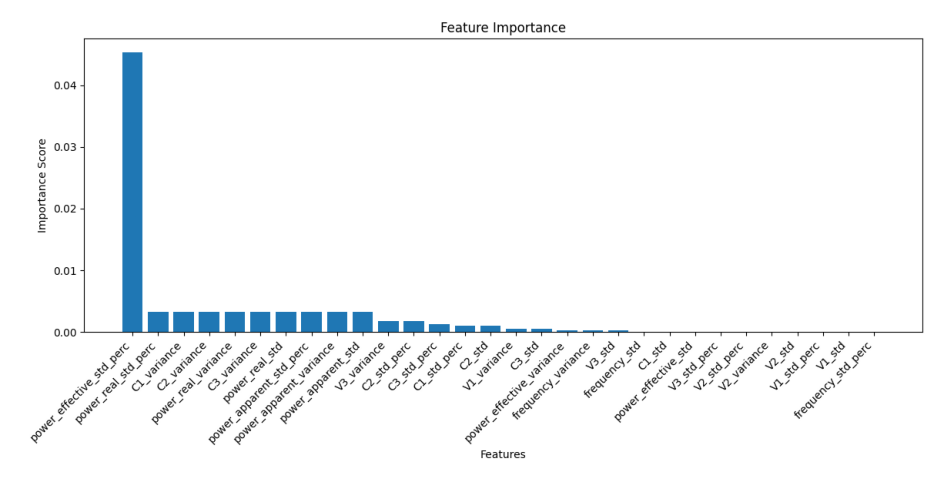

In [26]:
# Set your training parameters as strings

# Comma-separated list of files containing real power plant data
real_files_str = "processed_EPIC4.csv, processed_EPIC6.csv"

# Comma-separated list of files containing simulated power plant data
simulated_files_str = "1Panda.csv, 3Mosaik.csv, 4Mosaik_denoised.csv"

# Specific column to analyze (leave blank to analyze all columns)
# Examples: "V1", "C2", "frequency"
target_column = ""






# Path where the trained model will be saved
model_path = "svm_model.joblib"


real_files = parse_file_list(real_files_str)
simulated_files = parse_file_list(simulated_files_str)

# Show summary of parameters
print(f"Real data files: {len(real_files)} file(s)")
for f in real_files:
    print(f"  - {f}")

print(f"\nSimulated data files: {len(simulated_files)} file(s)")
for f in simulated_files:
    print(f"  - {f}")

print(f"\nModel will be saved to: {model_path}")

if target_column:
    print(f"Training will focus on column: {target_column}")
else:
    print("Training will analyze all available columns")

# Execute training if files are available
if real_files and simulated_files:
    print("\nStarting training...\n")

    # Prepare training data + labels
    training_files = real_files + simulated_files
    labels = [1] * len(real_files) + [0] * len(simulated_files)

    # Train model
    target_col = target_column if target_column else None
    success = galileo.train_and_save_model(training_files, labels, model_path, target_column=target_col)

    if success:
        print("\n✅ Training completed successfully!")

        # Display feature importance plot if it exists
        if os.path.exists('feature_importance.png'):
            plt.figure(figsize=(12, 6))
            img = plt.imread('feature_importance.png')
            plt.imshow(img)
            plt.axis('off')
            plt.show()
    else:
        print("\n❌ Training failed. Please check the error messages above.")
else:
    print("\n❌ ERROR: Both real and simulated files are required for training")

# TESTING
Set testing parameter as string (csv_files_str, target_column).

Example:
*   csv_files_str = "*.csv"
*   csv_files_str = "4Panda.csv"
*   csv_files_str = "2Panda.csv, processed_EPIC4.csv"





In [27]:
# Set your analysis parameters as strings

csv_files_str = "*.csv"  # Comma-separated list of files to analyze

target_column = ""  # Specific column to analyze (leave blank to use what the model was trained on)






model_path = "svm_model.joblib"  # Path to your trained model

# Parse the file list
csv_files = parse_file_list(csv_files_str)

print(f"Files to analyze one by one: {len(csv_files)} file(s)")
for f in csv_files:
    print(f"  - {f}")

# Check if model exists
if not os.path.exists(model_path):
    print(f"\n❌ ERROR: Model file '{model_path}' not found")

if target_column:
    print(f"Analysis will focus on column: {target_column}")
else:
    print("Analysis will use the column(s) the model was trained on")

# Set up target column parameter
target_col = target_column if target_column else None

# Test each file one by one
if csv_files and os.path.exists(model_path):
    for i, file_path in enumerate(csv_files):
        print(f"\n{'='*50}")
        print(f"ANALYZING FILE {i+1}/{len(csv_files)}: {file_path}")
        print(f"{'='*50}\n")

        # Analyze the file
        results = galileo.analyze_with_model(file_path, model_path, target_column=target_col)

        # Display results
        if results:
            display_results(results)

            # Add a markdown separator for better visual organization
            display(Markdown("---"))
        else:
            print(f"❌ Analysis failed for {file_path}")
            display(Markdown("---"))

    print("\nAll files have been analyzed.")
else:
    print("\nAnalysis skipped due to missing files or model.")

Files to analyze one by one: 26 file(s)
  - processed_EPIC3.csv
  - 1Mosaik_denoised.csv
  - 1Panda.csv
  - 3Mosaik_denoised.csv
  - processed_EPIC6.csv
  - 1GAN.csv
  - 1Panda_denoised.csv
  - processed_EPIC4.csv
  - 3Panda.csv
  - 4Panda_denoised.csv
  - 2Panda.csv
  - 2Mosaik.csv
  - 4Mosaik.csv
  - 4Panda.csv
  - 2Panda_denoised.csv
  - 4Mosaik_denoised.csv
  - processed_EPIC7.csv
  - 2Mosaik_denoised.csv
  - 2GAN.csv
  - 3Mosaik.csv
  - processed_EPIC1.csv
  - processed_EPIC2.csv
  - 1Mosaik.csv
  - 3Panda_denoised.csv
  - processed_EPIC8.csv
  - processed_EPIC5.csv
Analysis will use the column(s) the model was trained on

ANALYZING FILE 1/26: processed_EPIC3.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:green;font-weight:bold;'>REAL</span>

**Confidence:** <span style='color:green;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **101**

Windows classified as real: **101** (100.0%)

Windows classified as simulated: **0** (0.0%)

---


ANALYZING FILE 2/26: 1Mosaik_denoised.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>98%</span>

### Window Statistics

Total windows analyzed: **239**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **239** (100.0%)

---


ANALYZING FILE 3/26: 1Panda.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **223**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **223** (100.0%)

---


ANALYZING FILE 4/26: 3Mosaik_denoised.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>98%</span>

### Window Statistics

Total windows analyzed: **99**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **99** (100.0%)

---


ANALYZING FILE 5/26: processed_EPIC6.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:green;font-weight:bold;'>REAL</span>

**Confidence:** <span style='color:green;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **5**

Windows classified as real: **5** (100.0%)

Windows classified as simulated: **0** (0.0%)

---


ANALYZING FILE 6/26: 1GAN.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>67%</span>

### Window Statistics

Total windows analyzed: **199**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **199** (100.0%)

---


ANALYZING FILE 7/26: 1Panda_denoised.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>98%</span>

### Window Statistics

Total windows analyzed: **239**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **239** (100.0%)

---


ANALYZING FILE 8/26: processed_EPIC4.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:green;font-weight:bold;'>REAL</span>

**Confidence:** <span style='color:green;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **82**

Windows classified as real: **82** (100.0%)

Windows classified as simulated: **0** (0.0%)

---


ANALYZING FILE 9/26: 3Panda.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>97%</span>

### Window Statistics

Total windows analyzed: **84**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **84** (100.0%)

---


ANALYZING FILE 10/26: 4Panda_denoised.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>98%</span>

### Window Statistics

Total windows analyzed: **79**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **79** (100.0%)

---


ANALYZING FILE 11/26: 2Panda.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **547**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **547** (100.0%)

---


ANALYZING FILE 12/26: 2Mosaik.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>97%</span>

### Window Statistics

Total windows analyzed: **145**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **145** (100.0%)

---


ANALYZING FILE 13/26: 4Mosaik.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **21**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **21** (100.0%)

---


ANALYZING FILE 14/26: 4Panda.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **67**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **67** (100.0%)

---


ANALYZING FILE 15/26: 2Panda_denoised.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>98%</span>

### Window Statistics

Total windows analyzed: **599**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **599** (100.0%)

---


ANALYZING FILE 16/26: 4Mosaik_denoised.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>98%</span>

### Window Statistics

Total windows analyzed: **59**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **59** (100.0%)

---


ANALYZING FILE 17/26: processed_EPIC7.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:green;font-weight:bold;'>REAL</span>

**Confidence:** <span style='color:green;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **4**

Windows classified as real: **4** (100.0%)

Windows classified as simulated: **0** (0.0%)

---


ANALYZING FILE 18/26: 2Mosaik_denoised.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>98%</span>

### Window Statistics

Total windows analyzed: **599**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **599** (100.0%)

---


ANALYZING FILE 19/26: 2GAN.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>67%</span>

### Window Statistics

Total windows analyzed: **48**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **48** (100.0%)

---


ANALYZING FILE 20/26: 3Mosaik.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **31**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **31** (100.0%)

---


ANALYZING FILE 21/26: processed_EPIC1.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:green;font-weight:bold;'>REAL</span>

**Confidence:** <span style='color:green;font-weight:bold;'>96%</span>

### Window Statistics

Total windows analyzed: **3**

Windows classified as real: **3** (100.0%)

Windows classified as simulated: **0** (0.0%)

---


ANALYZING FILE 22/26: processed_EPIC2.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:green;font-weight:bold;'>REAL</span>

**Confidence:** <span style='color:green;font-weight:bold;'>94%</span>

### Window Statistics

Total windows analyzed: **6**

Windows classified as real: **5** (83.3%)

Windows classified as simulated: **1** (16.7%)

---


ANALYZING FILE 23/26: 1Mosaik.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>97%</span>

### Window Statistics

Total windows analyzed: **70**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **70** (100.0%)

---


ANALYZING FILE 24/26: 3Panda_denoised.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:red;font-weight:bold;'>SIMULATED</span>

**Confidence:** <span style='color:red;font-weight:bold;'>98%</span>

### Window Statistics

Total windows analyzed: **99**

Windows classified as real: **0** (0.0%)

Windows classified as simulated: **99** (100.0%)

---


ANALYZING FILE 25/26: processed_EPIC8.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:green;font-weight:bold;'>REAL</span>

**Confidence:** <span style='color:green;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **10**

Windows classified as real: **10** (100.0%)

Windows classified as simulated: **0** (0.0%)

---


ANALYZING FILE 26/26: processed_EPIC5.csv

Analyzing all columns


### Analysis Results

**Classification:** <span style='color:green;font-weight:bold;'>REAL</span>

**Confidence:** <span style='color:green;font-weight:bold;'>99%</span>

### Window Statistics

Total windows analyzed: **22**

Windows classified as real: **22** (100.0%)

Windows classified as simulated: **0** (0.0%)

---


All files have been analyzed.
